## NN: predict SIF using MODIS relectance

In [18]:
import warnings
warnings.simplefilter(action='ignore')
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from   sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
import keras.backend as K
from keras import regularizers
from keras.layers import Input, Dense
from keras.models import Model, load_model
from keras.utils  import plot_model
from keras.constraints import NonNeg
from IPython.display   import Image
from scipy.interpolate import interpn
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [19]:
os.chdir('/Users/weiweizhan/Desktop/Weiwei_Zhan/Projects/SIF_Predict/yao_sif_code/habanero/')

trainingDataDir  = './training/'

nc_file         = trainingDataDir+'mcd43_b7_sza_vpd_temp_sif_training.nc4'  
# nc_file         = trainingDataDir+'file_2015_2016_QA_more.nc'
nc_file_mean    = trainingDataDir+'mcd43_b7_sza_vpd_temp_sif_training_mean.nc' 
nc_file_std     = trainingDataDir+'mcd43_b7_sza_vpd_temp_sif_training_std.nc'  

# nc_file         = trainingDataDir+'file_2015_2016_1.nc'

In [20]:
data      = xr.open_dataset(nc_file)
data_mean = xr.open_dataset(nc_file_mean)
data_std  = xr.open_dataset(nc_file_std)

# MODIS
b1      = data.b1.values
b2      = data.b2.values
cos_sza = data.sza.values
sif     = data.sif_757nm.values

sif, b1, b2, cos_sza = (x[:,None] for x in [sif,b1,b2,cos_sza])

b1_mean, b2_mean,cos_sza_mean  = np.mean(b1),np.mean(b2),np.mean(cos_sza)
b1_std,  b2_std, cos_sza_std   = np.std(b1), np.std(b2), np.std(cos_sza)

# Normalization
b1_n      = ((b1-b1_mean)/b1_std)
b2_n      = ((b2-b2_mean)/b2_std)
cos_sza_n = ((cos_sza-cos_sza_mean)/cos_sza_std)
# sif_n     = ((sif-sif_mean)/sif_std)[:,None]

MOD_input = np.concatenate([b1_n, b2_n, cos_sza_n,sif],axis=-1)

# shuffle
np.random.shuffle(MOD_input)
print(MOD_input.shape)

In [23]:
# split into train & test sets
# All above data are training datasets
all_input    = MOD_input

train_indice = int(all_input.shape[0] * 0.7)
test_indice  = int(all_input.shape[0] * 0.3)
train_X      = all_input[:train_indice, :-1]
test_X       = all_input[-test_indice:, :-1]

train_sif    = all_input[:train_indice,-1]
test_sif     = all_input[-test_indice:,-1]

In [26]:
x_input = Input(shape=(train_X.shape[1],), dtype='float32', name='x_input')
x_1     = Dense(128, activation='relu',name='hidden1')(x_input)
# x_2       = Dense(16, activation='relu',name='hidden2')(x_1)
SIF     = Dense(1, name='SIF')(x_1)


model = Model(inputs=x_input, outputs=SIF)

# show model structure
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x_input (InputLayer)         (None, 3)                 0         
_________________________________________________________________
hidden1 (Dense)              (None, 128)               512       
_________________________________________________________________
SIF (Dense)                  (None, 1)                 129       
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.0005), loss='mse')

# fit model
model.fit({'x_input': train_X},
          {'SIF': train_sif},
          epochs=30, batch_size=1024)

Epoch 1/30
1172859/1172859 [==============================] - 2s 2us/step - loss: 0.0348
Epoch 2/30
1172859/1172859 [==============================] - 2s 1us/step - loss: 0.0324
Epoch 3/30
1172859/1172859 [==============================] - 2s 1us/step - loss: 0.0324
Epoch 4/30
1172859/1172859 [==============================] - 2s 1us/step - loss: 0.0324
Epoch 5/30
1172859/1172859 [==============================] - 2s 1us/step - loss: 0.0324
Epoch 6/30
1172859/1172859 [==============================] - 2s 1us/step - loss: 0.0324
Epoch 7/30
1172859/1172859 [==============================] - 2s 1us/step - loss: 0.0324
Epoch 8/30
1172859/1172859 [==============================] - 2s 1us/step - loss: 0.0324
Epoch 9/30
1172859/1172859 [==============================] - 2s 1us/step - loss: 0.0323
Epoch 10/30
1172859/1172859 [==============================] - 2s 2us/step - loss: 0.0323
Epoch 11/30
1172859/1172859 [==============================] - 2s 1us/step - loss: 0.0323
Epoch 12/30
1172859

In [28]:
path = './trained_model/MODIS_SIF_NN_Yaodata_SIForiginal_1516only.h5'
model.save(path)

# del model
# model      = load_model(path)
SIF_model  = Model(inputs = model.input, outputs= model.output)
SIF_pre     = SIF_model.predict({'x_input':  test_X})

In [31]:
def plot_dia(x,y,ax):
    max_value = max(max(x),max(y))
    min_value = min(min(x),min(y))
    x = np.linspace(min_value, max_value, 100)
    ax.plot(x, x,'--',color='darkred')

In [32]:
def scatter_plot(x, y, ax, fig, xlabel, ylabel, title):
    """scatter plot between two original time series, 
       and annotate the correlation coefficient on the plot"""
    
#     x,y = filter_nan(x_original, y_original)
    H, x_edge, y_edge = np.histogram2d(x, y, bins = 30)
    z = interpn((0.5*(x_edge[1:]+x_edge[:-1]), 0.5*(y_edge[1:]+y_edge[:-1])), H, 
                 np.vstack([x,y]).T, method='splinef2d', bounds_error = False )
    # Sort the points by density to make the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    # Scatter plot
    sc = ax.scatter( x, y, c=z, s=10,cmap='RdYlGn_r',
                    norm=colors.LogNorm(vmin=1), vmin=1,vmax=1e+5)
    max_value = max(max(x),max(y))
    min_value = min(min(x),min(y))
    diag_line = np.linspace(min_value, max_value, 100)
    ax.plot(diag_line, diag_line,'--',color='darkred')
    
    # Calculate the correlation coefficient 
#     slope, intercept, r_value, p_value, std_err = linregress(x, y)
    # Figure annotation
#     ax.annotate(f'R = {np.around(r_value,decimals=2)} \np = {np.around(p_value,decimals=2)}', 
#                 xy=(.05, .88), xycoords='axes fraction', fontweight='bold')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    cb = fig.colorbar(sc,ax=ax, shrink=0.8,label='Point Density')
    cb.set_label(label='Point Density') #,weight='bold'
    fig.suptitle(title, fontsize=17, fontweight='bold')

In [37]:
SIF_model  = Model(inputs = model.input, outputs= model.output)
SIF_pre    = SIF_model.predict({'x_input':  test_X})


plt.rcParams.update({'font.size': 15})
fig,ax=plt.subplots(figsize=(7,5.5))
SIF_pre = SIF_pre.reshape((SIF_pre.shape[0],))

scatter_plot(SIF_pre,test_sif,ax=ax,fig=fig,
             xlabel='Predicted SIF (mW/(m\N{SUPERSCRIPT TWO} nm sr))',
             ylabel='OCO-2 SIF (mW/(m\N{SUPERSCRIPT TWO} nm sr))',
             title='Validation')
ax.set_xlim(-1,3)
ax.set_ylim(-1,3)
plt.rcParams['savefig.dpi'] = 220
# plt.savefig('./figure/Validationset_SIF_Model1_1516.png')

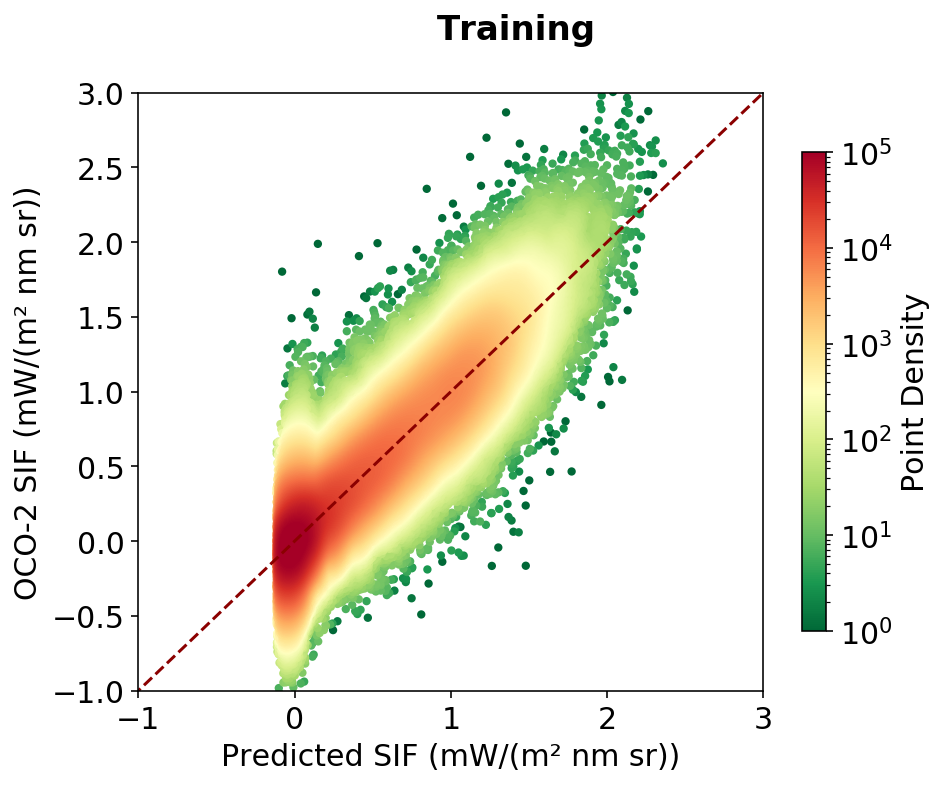

In [34]:
SIF_model  = Model(inputs = model.input, outputs= model.output)
SIF_pre     = SIF_model.predict({'x_input':  train_X})


plt.rcParams.update({'font.size': 15})
fig,ax=plt.subplots(figsize=(7,5.5))
SIF_pre_t = SIF_pre.reshape((SIF_pre.shape[0],))

scatter_plot(SIF_pre_t,train_sif,ax=ax,fig=fig,
             xlabel='Predicted SIF (mW/(m\N{SUPERSCRIPT TWO} nm sr))',
             ylabel='OCO-2 SIF (mW/(m\N{SUPERSCRIPT TWO} nm sr))',
             title='Training')
ax.set_xlim(-1,3)
ax.set_ylim(-1,3)
plt.rcParams['savefig.dpi'] = 220
# plt.savefig('./figure/Trainingset_SIF_Model1_1516.png')

In [38]:
import statsmodels.api as sm
X = SIF_pre
y = test_sif
print(X.shape,y.shape)
# Note the difference in argument order
model1 = sm.OLS(y, X).fit()
# predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model1.summary()

(502654, 1) (502654,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.860
Model:                            OLS   Adj. R-squared (uncentered):              0.860
Method:                 Least Squares   F-statistic:                          3.088e+06
Date:                Sun, 22 Dec 2019   Prob (F-statistic):                        0.00
Time:                        17:40:09   Log-Likelihood:                      1.5115e+05
No. Observations:              502654   AIC:                                 -3.023e+05
Df Residuals:                  502653   BIC:                                 -3.023e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9943      0.001   1757.274      0.000       0.993       0.995
==============================================================================
Omnibus:                    18935.367   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47616.977
Skew:                           0.189   Prob(JB):                         0.00
Kurtosis:                       4.460   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""